In [1]:
import pandas as pd
import numpy as np
import os
import operator
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression 

In [2]:
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

# Logistic Regression Model

In [3]:
train['size'] = train['slotwidth'] * train['slotheight']
validation['size'] = validation['slotwidth'] * validation['slotheight']
test['size'] = test['slotwidth'] * test['slotheight']
train['OS'], train['browser'] = zip(*train['useragent'].map(lambda x: x.split('_')))
validation['OS'], validation['browser'] = zip(*validation['useragent'].map(lambda x: x.split('_')))
test['OS'], test['browser'] = zip(*test['useragent'].map(lambda x: x.split('_')))

In [4]:
def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
    
    df.ix[df.slotprice.between(0, 10), 'slotpricebucket'] = 1
    df.ix[df.slotprice.between(11, 50), 'slotpricebucket'] = 2
    df.ix[df.slotprice.between(51, 100), 'slotpricebucket'] = 3
    df.ix[df.slotprice.between(101, 5000), 'slotpricebucket'] = 4
    df['slotpricebucket'] = df['slotpricebucket'].astype(np.uint8)

    pred=df.drop(['click','bidid','userid','IP','url','urlid','slotid','useragent','slotprice',
                 'bidprice','payprice','domain','slotwidth', 'slotheight'],axis=1)
    
    # create dummy variables for categoricals
    pred=pd.get_dummies(pred,dummy_na=True,columns=['weekday', 'hour', 
                                                       'OS', 'browser', 
                                                       'region', 'city', 'adexchange', 
                                                       'slotvisibility', 'slotformat',
                                                       'creative', 'slotpricebucket','advertiser'##'ip_block'
                                                    ,'keypage','size'])
    pred = pred.join(df.usertag.astype(str).str.strip('[]').str.get_dummies(','))
    pred=pred.drop(['usertag'],axis=1)
    print("After converting categoricals:\t{}".format(pred.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(pred.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, pred.columns)
        print(to_add)
        print(to_drop)
        pred.drop(to_drop, axis=1, inplace=True)
        pred = pred.assign(**{c: 0 for c in to_add})
    
    pred.fillna(0, inplace=True)
    
    return pred


def pre_process_data_test(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
    
    df.ix[df.slotprice.between(0, 10), 'slotpricebucket'] = 1
    df.ix[df.slotprice.between(11, 50), 'slotpricebucket'] = 2
    df.ix[df.slotprice.between(51, 100), 'slotpricebucket'] = 3
    df.ix[df.slotprice.between(101, 5000), 'slotpricebucket'] = 4
    df['slotpricebucket'] = df['slotpricebucket'].astype(np.uint8)

    pred=df.drop(['bidid','userid','IP','url','urlid','slotid','useragent','slotprice',
                 'domain','slotwidth', 'slotheight'],axis=1)
    
       # create dummy variables for categoricals
    pred = pd.get_dummies(pred,dummy_na=True,columns=['weekday', 'hour',  # ])
                                                       'OS', 'browser', 
                                                       'region', 'city', 'adexchange', 
                                                       'slotvisibility', 'slotformat',
                                                       'creative', 'slotpricebucket','advertiser'##'ip_block'
                                                    ,'keypage','size'])
    pred = pred.join(df.usertag.astype(str).str.strip('[]').str.get_dummies(','))
    pred = pred.drop(['usertag'],axis=1)
    print("After converting categoricals:\t{}".format(pred.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(pred.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, pred.columns)
        print(to_add)
        print(to_drop)
        pred.drop(to_drop, axis=1, inplace=True)
        pred = pred.assign(**{c: 0 for c in to_add})
    
    pred.fillna(0, inplace=True)
    
    return pred

In [5]:
train_dum = pre_process_data(train)
valid_dum = pre_process_data(validation,enforce_cols=train_dum.columns)
test_dum = pre_process_data_test(test,enforce_cols=train_dum.columns)

Input shape:	(2430981, 28)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


After converting categoricals:	(2430981, 741)
Input shape:	(303925, 28)
After converting categoricals:	(303925, 739)
['creative_7324' 'creative_7332']
[]
Input shape:	(303375, 25)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


After converting categoricals:	(303375, 739)
['creative_7324' 'creative_7327']
[]


In [6]:
y = train.click
y_validation = validation.click

In [7]:
def order(df_test, df_train):
    new_df = pd.DataFrame()
    
    for key in df_train:
        new_df[key] = df_test[key]
    return new_df
X_validation = order(valid_dum,train_dum)
X_test = order(test_dum,train_dum)

In [8]:
rus = RandomUnderSampler(random_state=3,ratio={1:1786,0:10716})
X_train,y_train = rus.fit_sample(train_dum,y)

In [9]:
model_LR = LogisticRegression(penalty = 'l1', max_iter = 100, C = 0.1,
                              solver = 'saga',class_weight = 'unbalanced')
model_LR.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='unbalanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [10]:
#X_validation = X_validation.as_matrix()
y_valid_pre = model_LR.predict_proba(X_validation)
pCTRval = pd.DataFrame(y_valid_pre)

In [11]:
#X_test = X_test.as_matrix()
y_test_pre = model_LR.predict_proba(X_test)
pCTRtest = pd.DataFrame(y_test_pre)

In [12]:
w=10716/train.shape[0]
avgCTR=sum(train.click)/train.shape[0]

test_score = y_test_pre[:,1]/(y_test_pre[:,1]+(1-y_test_pre[:,1])/w)
valid_score = y_valid_pre[:,1]/(y_valid_pre[:,1]+(1-y_valid_pre[:,1])/w)

# Linear Strategy

In [13]:
eval_linear = pd.DataFrame(columns=['bid_base','Imps','spend','clicks'])

max_num = 0
max_bid = 0
spend = 0
iteration = 0

for bid_base in np.arange(3,300, 3):
    num_click = 0
    flag = True
    Imps = 0
    spend = 0
    iteration += 1
    for i in range(validation.shape[0]):
        bid = bid_base*(valid_score[i]/avgCTR)
        if bid >= validation.payprice[i] and flag:
            spend = spend + validation.payprice[i]
            if spend > 6250000:
                spend = spend - validation.payprice[i]
                flag = False
                break
            num_click = num_click + validation.click[i]
            Imps = Imps + 1
    eval_linear.loc[iteration,'bid_base'] = bid_base
    eval_linear.loc[iteration,'clicks'] = num_click
    eval_linear.loc[iteration,'spend'] = spend/1000
    eval_linear.loc[iteration,'Imps'] = Imps

    if num_click > max_num:
        max_num = num_click
        max_bid = bid_base
        
eval_linear['CTR'] = eval_linear['clicks']/eval_linear['Imps']
eval_linear['eCPC'] = eval_linear['spend']/eval_linear['clicks']
eval_linear['CPM'] = eval_linear['spend']*1000/eval_linear['Imps']

In [16]:
eval_linear.iloc[np.where(eval_linear.clicks == eval_linear.clicks.max())[0]]

,bid_base,Imps,spend,clicks,CTR,eCPC,CPM
33,99,132199,6155.03,159,0.00120273,38.7109,46.5589


In [21]:
eval_linear[28:37]

,bid_base,Imps,spend,clicks,CTR,eCPC,CPM
29,87,118398,5276.9,155,0.00130914,34.0445,44.5691
30,90,121949,5497.41,156,0.00127922,35.2398,45.0796
31,93,125468,5718.31,156,0.00124334,36.6558,45.5758
32,96,128824,5934.85,157,0.00121872,37.8016,46.0694
33,99,132199,6155.03,159,0.00120273,38.7109,46.5589
34,102,133163,6249.96,156,0.0011715,40.0639,46.9347
35,105,131907,6249.98,147,0.00111442,42.5169,47.3817
36,108,130782,6249.95,143,0.00109342,43.706,47.7891
37,111,129819,6249.91,141,0.00108613,44.3256,48.1433


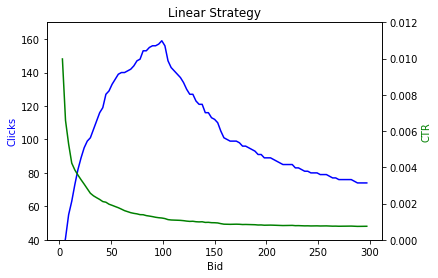

In [15]:
first_line = eval_linear[['bid_base','clicks']].astype(float)
second_line = eval_linear[['bid_base','CTR']].astype(float)

fig, ax1 = plt.subplots()
ax1.plot(first_line.bid_base,first_line.clicks, color='b')
ax1.set_xlabel('Bid')
ax1.set_ylabel('Clicks', color='b')
ax1.set_ylim([40,170])

ax2 = ax1.twinx()
ax2.plot(second_line.bid_base, second_line.CTR, color='g')
ax2.set_ylabel('CTR', color='g')
ax2.set_ylim([0,0.012])
             
plt.title("Linear Strategy")
plt.show()